### Checking for the Availability of Cuda

In [2]:
import torch
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
else:
    print("No GPU available")

NVIDIA GeForce RTX 3060 Laptop GPU


In [3]:
!nvidia-smi

Thu May  9 18:53:59 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 552.22                 Driver Version: 552.22         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   52C    P5             18W /  101W |    1356MiB /   6144MiB |     22%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Importing all the required Modules

In [1]:
import os
from pathlib import Path
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import random
import ultralytics
from ultralytics import YOLO
import IPython
from IPython.display import display, Image

## Classification Task

### Hyper paramter testing on ResNet Model

In [7]:
class BleedingDataset(Dataset):
    def __init__(self, bleeding_dir, non_bleeding_dir, transform=None):
        self.bleeding_dir = bleeding_dir
        self.non_bleeding_dir = non_bleeding_dir
        self.transform = transform
        self.bleeding_images = list(Path(bleeding_dir).glob('*'))
        self.non_bleeding_images = list(Path(non_bleeding_dir).glob('*'))

    def __len__(self):
        return len(self.bleeding_images) + len(self.non_bleeding_images)

    def __getitem__(self, idx):
        if idx < len(self.bleeding_images):
            img_path = self.bleeding_images[idx]
            label = 1
        else:
            img_path = self.non_bleeding_images[idx - len(self.bleeding_images)]
            label = 0
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Hyperparameters space
hyperparameters = {
    'learning_rate': [1e-3, 1e-5],
    'batch_size': [32, 64],
    'num_epochs': [20, 25],
    'optimizer': ['adam', 'sgd']
}

# Sample hyperparameters
def sample_hyperparameters(hyperparameters):
    sampled_hyperparams = {}
    for key, values in hyperparameters.items():
        sampled_hyperparams[key] = random.choice(values)
    return sampled_hyperparams

# Train and evaluate model
def train_and_evaluate_model(hparams, device, bleeding_dir, non_bleeding_dir):
    start_time = time.time()  # Start the timer

    model = models.resnet50(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)
    model = model.to(device)

    if hparams['optimizer'] == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=hparams['learning_rate'])
    elif hparams['optimizer'] == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=hparams['learning_rate'], momentum=0.9)

    criterion = nn.CrossEntropyLoss()
    data_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ])

    dataset = BleedingDataset(bleeding_dir, non_bleeding_dir, data_transforms)
    dataloader = DataLoader(dataset, batch_size=hparams['batch_size'], shuffle=True)

    model.train()
    for epoch in range(hparams['num_epochs']):
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    end_time = time.time()  # End the timer
    elapsed_time = end_time - start_time  # Calculate the elapsed time

    # Clear GPU cache
    torch.cuda.empty_cache()

    return accuracy, elapsed_time

# Path setup
bleeding_dir = r"C:\Users\Shreyank_SH\OneDrive\Desktop\RVU\sem4\IML\SEM_LONG\WCEBleedGen_dataset\bled_200"
non_bleeding_dir = r"C:\Users\Shreyank_SH\OneDrive\Desktop\RVU\sem4\IML\SEM_LONG\WCEBleedGen_dataset\non_bled_200"

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Random Search
n_iterations = 10
best_accuracy = 0
best_time = float('inf')
best_hparams = None

for _ in range(n_iterations):
    hparams = sample_hyperparameters(hyperparameters)
    accuracy, elapsed_time = train_and_evaluate_model(hparams, device, bleeding_dir, non_bleeding_dir)
    print(f'Tested {hparams} with accuracy {accuracy} and time {elapsed_time}')

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_hparams = hparams
        best_time = elapsed_time
    elif accuracy == best_accuracy and elapsed_time < best_time:
        best_hparams = hparams
        best_time = elapsed_time

print(f'Best hyperparameters: {best_hparams} with accuracy: {best_accuracy} and time: {best_time}')

Tested {'learning_rate': 0.001, 'batch_size': 64, 'num_epochs': 20, 'optimizer': 'adam'} with accuracy 0.9975 and time 669.2981376647949
Tested {'learning_rate': 1e-05, 'batch_size': 64, 'num_epochs': 20, 'optimizer': 'sgd'} with accuracy 0.89 and time 347.5954840183258
Tested {'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 25, 'optimizer': 'adam'} with accuracy 1.0 and time 73.81701850891113
Tested {'learning_rate': 1e-05, 'batch_size': 32, 'num_epochs': 20, 'optimizer': 'sgd'} with accuracy 0.96 and time 52.0591082572937
Tested {'learning_rate': 1e-05, 'batch_size': 64, 'num_epochs': 20, 'optimizer': 'adam'} with accuracy 1.0 and time 442.2844970226288
Tested {'learning_rate': 1e-05, 'batch_size': 64, 'num_epochs': 25, 'optimizer': 'sgd'} with accuracy 0.895 and time 583.4538335800171
Tested {'learning_rate': 1e-05, 'batch_size': 64, 'num_epochs': 25, 'optimizer': 'sgd'} with accuracy 0.81 and time 534.7207896709442
Tested {'learning_rate': 1e-05, 'batch_size': 32, 'num_epoc

### Training the Resnet50 Model and Testing it with the Complete Training set

Epoch 1/20
Loss: 0.3649, Acc: 0.8770

Confusion Matrix:
[[1180  129]
 [ 193 1116]]
F1 Score: 0.8739
Precision: 0.8964
Recall: 0.8526
Accuracy: 0.8770
-------------------------

Epoch 2/20
Loss: 0.0803, Acc: 0.9878

Confusion Matrix:
[[1301    8]
 [  24 1285]]
F1 Score: 0.9877
Precision: 0.9938
Recall: 0.9817
Accuracy: 0.9878
-------------------------

Epoch 3/20
Loss: 0.0285, Acc: 0.9962

Confusion Matrix:
[[1306    3]
 [   7 1302]]
F1 Score: 0.9962
Precision: 0.9977
Recall: 0.9947
Accuracy: 0.9962
-------------------------

Epoch 4/20
Loss: 0.0114, Acc: 0.9996

Confusion Matrix:
[[1308    1]
 [   0 1309]]
F1 Score: 0.9996
Precision: 0.9992
Recall: 1.0000
Accuracy: 0.9996
-------------------------

Epoch 5/20
Loss: 0.0063, Acc: 1.0000

Confusion Matrix:
[[1309    0]
 [   0 1309]]
F1 Score: 1.0000
Precision: 1.0000
Recall: 1.0000
Accuracy: 1.0000
-------------------------

Epoch 6/20
Loss: 0.0046, Acc: 1.0000

Confusion Matrix:
[[1309    0]
 [   0 1309]]
F1 Score: 1.0000
Precision: 1.00

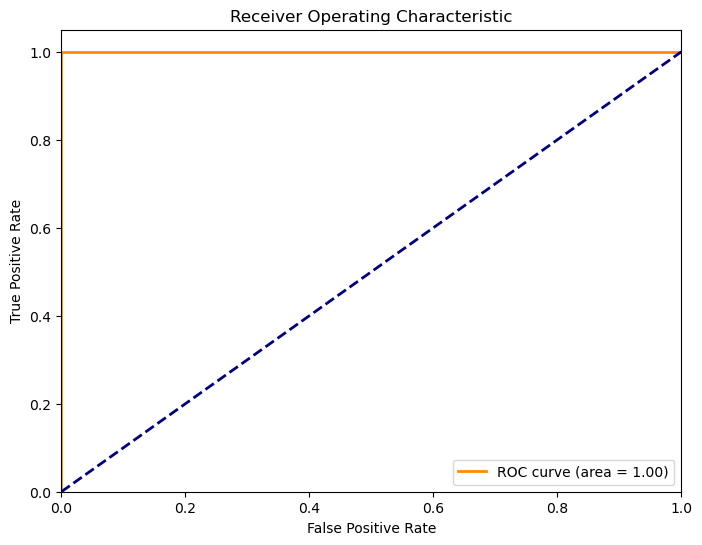

In [8]:
class BleedingDataset(Dataset):
    def __init__(self, bleeding_dir, non_bleeding_dir, transform=None):
        self.bleeding_dir = bleeding_dir
        self.non_bleeding_dir = non_bleeding_dir
        self.transform = transform
        self.bleeding_images = list(Path(bleeding_dir).glob('*'))
        self.non_bleeding_images = list(Path(non_bleeding_dir).glob('*'))

    def __len__(self):
        return len(self.bleeding_images) + len(self.non_bleeding_images)

    def __getitem__(self, idx):
        if idx < len(self.bleeding_images):
            img_path = self.bleeding_images[idx]
            label = 1
        else:
            img_path = self.non_bleeding_images[idx - len(self.bleeding_images)]
            label = 0
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image, label

# Model definition
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

# Hyperparameters
learning_rate = 0.00001
batch_size = 32
num_epochs = 20

# DataLoader preparation
data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

bleeding_dir = r"C:\Users\Shreyank_SH\OneDrive\Desktop\RVU\sem4\IML\SEM_LONG\WCEBleedGen_dataset\bleeding\Images"
non_bleeding_dir = r"C:\Users\Shreyank_SH\OneDrive\Desktop\RVU\sem4\IML\SEM_LONG\WCEBleedGen_dataset\non-bleeding\images"
dataset = BleedingDataset(bleeding_dir, non_bleeding_dir, data_transforms)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Check if CUDA is available and move the model to the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Training loop setup
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    running_corrects = 0
    all_labels = []
    all_preds = []
    all_probs = []
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs, 1)
        probs = torch.nn.functional.softmax(outputs, dim=1)[:, 1]  # Probability of 'bleeding'
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().detach().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects / len(dataloader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}')
    
    # Evaluation
    conf_mat = confusion_matrix(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    accuracy = accuracy_score(all_labels, all_preds)

    print("\nConfusion Matrix:")
    print(conf_mat)
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print("-------------------------")
    print()

# Save the trained model
torch.save(model.state_dict(), "C:/Users/Shreyank_SH/OneDrive/Desktop/RVU/sem4/IML/SEM_LONG/model50_with_hyperparameter.pth")

# Plot ROC curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Testing the Classification Model on Unseen Data

In [17]:
# Clearing previous cache
torch.cuda.empty_cache()

# Delete all exsiting files in the 'Predicted_Bleeding_Images' folder
bleeding_dir = r"C:\Users\Shreyank_SH\OneDrive\Desktop\RVU\sem4\IML\SEM_LONG\Predicted_Bleeding_Images"
for filename in os.listdir(bleeding_dir):
    file_path = os.path.join(bleeding_dir, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print(f'Failed to delete {file_path}. Reason: {e}')
print("Deleted the exciting contents in 'Predicted_Bleeding_Images' folder")

# Delete all exsiting files in the 'Predicted_Non_Bleeding_Images' folder
non_bleeding_dir = r"C:\Users\Shreyank_SH\OneDrive\Desktop\RVU\sem4\IML\SEM_LONG\Predicted_Non_Bleeding_Images"
for filename in os.listdir(non_bleeding_dir):
    file_path = os.path.join(non_bleeding_dir, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print(f'Failed to delete {file_path}. Reason: {e}')
print("Deleted the exciting contents in 'Predicted_Non_Bleeding_Images' folder")


# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

# Define data transformations for test dataset
test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

# Test dataset directory
test_dir = r"C:\Users\Shreyank_SH\OneDrive\Desktop\RVU\sem4\IML\SEM_LONG\Test\Test Dataset 2\Images"

# Create directories to store images classified as 'Bleeding' and 'Non-Bleeding'
# Adding classified images as non-bleeding and bleeding into seperate folders
bleeding_dir = r"C:\Users\Shreyank_SH\OneDrive\Desktop\RVU\sem4\IML\SEM_LONG\Predicted_Bleeding_Images"
non_bleeding_dir = r"C:\Users\Shreyank_SH\OneDrive\Desktop\RVU\sem4\IML\SEM_LONG\Predicted_Non_Bleeding_Images"

os.makedirs(bleeding_dir, exist_ok=True)
os.makedirs(non_bleeding_dir, exist_ok=True)

# Define class labels
class_labels = ['Non-Bleeding', 'Bleeding']

class BleedingDataset(Dataset):
    def __init__(self, test_dir, transform=None):
        self.test_dir = test_dir
        self.transform = transform
        self.test_images = list(Path(test_dir).glob('*'))

    def __len__(self):
        return len(self.test_images)

    def __getitem__(self, idx):
        img_path = self.test_images[idx]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image

# Create a dataset for the test data
test_dataset = BleedingDataset(test_dir, test_transforms)

# Create a DataLoader for the test dataset
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Load the pre-trained model
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

# Load the trained model state
model.load_state_dict(torch.load('C:/Users/Shreyank_SH/OneDrive/Desktop/RVU/sem4/IML/SEM_LONG/model50_with_hyperparameter.pth'))

# Move the model to the appropriate device
model = model.to(device)

# Place the model in evaluation mode
model.eval()

# Iterate through the test dataset and make predictions
for i, (inputs, img_path) in enumerate(zip(test_dataloader, test_dataset.test_images)):
    # Move inputs to the appropriate device
    inputs = inputs.to(device)

    # Forward pass
    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

    # Map predicted class index to class label
    predicted_label = class_labels[preds.item()]

    # Print the predicted label for the current image
    print(f"Image {i + 1}: Predicted Label: {predicted_label}")

    # Copy the image to the appropriate folder based on the predicted label
    if predicted_label == 'Bleeding':
        shutil.copy(str(img_path), bleeding_dir)
    else:
        shutil.copy(str(img_path), non_bleeding_dir)

print(f"\nImages classified as 'Bleeding' have been copied to {bleeding_dir}")
print(f"Images classified as 'Non-Bleeding' have been copied to {non_bleeding_dir}")
torch.cuda.empty_cache()

Deleted the exciting contents in 'Predicted_Bleeding_Images' folder
Deleted the exciting contents in 'Predicted_Non_Bleeding_Images' folder
Using cuda device
Image 1: Predicted Label: Non-Bleeding
Image 2: Predicted Label: Bleeding
Image 3: Predicted Label: Non-Bleeding
Image 4: Predicted Label: Non-Bleeding
Image 5: Predicted Label: Non-Bleeding
Image 6: Predicted Label: Non-Bleeding
Image 7: Predicted Label: Non-Bleeding
Image 8: Predicted Label: Non-Bleeding
Image 9: Predicted Label: Non-Bleeding
Image 10: Predicted Label: Non-Bleeding
Image 11: Predicted Label: Non-Bleeding
Image 12: Predicted Label: Non-Bleeding
Image 13: Predicted Label: Non-Bleeding
Image 14: Predicted Label: Non-Bleeding
Image 15: Predicted Label: Bleeding
Image 16: Predicted Label: Non-Bleeding
Image 17: Predicted Label: Non-Bleeding
Image 18: Predicted Label: Non-Bleeding
Image 19: Predicted Label: Non-Bleeding
Image 20: Predicted Label: Non-Bleeding
Image 21: Predicted Label: Non-Bleeding
Image 22: Predicted

## Detection task

### Pip Installing required modules

In [4]:
!pip install ultralytics

In [7]:
!pip install ultralytics==8.0.20

ERROR: Ignored the following yanked versions: 8.0.129, 8.0.174, 8.0.177, 8.1.21, 8.1.31, 8.2.7
ERROR: Ignored the following versions that require a different python version: 8.0.10 Requires-Python >=3.7,<=3.11; 8.0.11 Requires-Python >=3.7,<=3.11; 8.0.12 Requires-Python >=3.7,<=3.11; 8.0.13 Requires-Python >=3.7,<=3.11; 8.0.14 Requires-Python >=3.7,<=3.11; 8.0.15 Requires-Python >=3.7,<=3.11; 8.0.16 Requires-Python >=3.7,<=3.11; 8.0.17 Requires-Python >=3.7,<=3.11; 8.0.18 Requires-Python >=3.7,<=3.11; 8.0.19 Requires-Python >=3.7,<=3.11; 8.0.20 Requires-Python >=3.7,<=3.11; 8.0.21 Requires-Python >=3.7,<=3.11; 8.0.22 Requires-Python >=3.7,<=3.11; 8.0.23 Requires-Python >=3.7,<=3.11; 8.0.24 Requires-Python >=3.7,<=3.11; 8.0.25 Requires-Python >=3.7,<=3.11; 8.0.26 Requires-Python >=3.7,<=3.11; 8.0.27 Requires-Python >=3.7,<=3.11; 8.0.28 Requires-Python >=3.7,<=3.11; 8.0.29 Requires-Python >=3.7,<=3.11; 8.0.30 Requires-Python >=3.7,<=3.11; 8.0.31 Requires-Python >=3.7,<=3.11; 8.0.32 Requi

In [ ]:
pip install --upgrade ultralytics

     ---------------------------------------- 0.0/40.7 kB ? eta -:--:--
     ---------- ----------------------------- 10.2/40.7 kB ? eta -:--:--
     ---------------------------- --------- 30.7/40.7 kB 325.1 kB/s eta 0:00:01
     -------------------------------------- 40.7/40.7 kB 324.0 kB/s eta 0:00:00
   ---------------------------------------- 0.0/755.6 kB ? eta -:--:--
   ---- ----------------------------------- 92.2/755.6 kB 2.6 MB/s eta 0:00:01
   ------------------------------------- -- 716.8/755.6 kB 9.1 MB/s eta 0:00:01
   ---------------------------------------- 755.6/755.6 kB 9.6 MB/s eta 0:00:00
  Attempting uninstall: ultralytics
    Found existing installation: ultralytics 8.2.7
    Uninstalling ultralytics-8.2.7:
      Successfully uninstalled ultralytics-8.2.7
Note: you may need to restart the kernel to use updated packages.


In [14]:
ultralytics.checks()

Ultralytics YOLOv8.2.10  Python-3.11.7 torch-2.3.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Setup complete  (16 CPUs, 15.2 GB RAM, 338.0/429.7 GB disk)


In [5]:
HOME = os.getcwd()
print(HOME)

c:\Users\Shreyank_SH\OneDrive\Desktop\RVU\sem4\IML\SEM_LONG


### Model Training

In [ ]:
torch.cuda.empty_cache()
%cd c:/Users/Shreyank_SH/OneDrive/Desktop/RVU/sem4/IML/SEM_LONG
!yolo detect mode=train data=data.yaml model=yolov8m.pt epochs=10 lr0=0.001 plots=True

c:\Users\Shreyank_SH\OneDrive\Desktop\RVU\sem4\IML\SEM_LONG
New https://pypi.org/project/ultralytics/8.2.11 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.10 🚀 Python-3.11.7 torch-2.3.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine\trainer: task=detect, mode=train, model=yolov8m.pt, data=data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=Fals


  0%|          | 0.00/49.7M [00:00<?, ?B/s]
  0%|          | 128k/49.7M [00:00<01:01, 840kB/s]
  1%|          | 384k/49.7M [00:00<00:43, 1.18MB/s]
  1%|▏         | 640k/49.7M [00:00<00:35, 1.44MB/s]
  2%|▏         | 896k/49.7M [00:00<00:37, 1.38MB/s]
  2%|▏         | 1.12M/49.7M [00:00<00:41, 1.23MB/s]
  3%|▎         | 1.38M/49.7M [00:01<00:44, 1.14MB/s]
  3%|▎         | 1.50M/49.7M [00:01<00:48, 1.04MB/s]
  4%|▎         | 1.75M/49.7M [00:01<00:48, 1.04MB/s]
  4%|▍         | 2.00M/49.7M [00:01<00:48, 1.04MB/s]
  4%|▍         | 2.12M/49.7M [00:01<00:46, 1.08MB/s]
  5%|▍         | 2.25M/49.7M [00:02<00:47, 1.05MB/s]
  5%|▌         | 2.50M/49.7M [00:02<00:43, 1.13MB/s]
  5%|▌         | 2.62M/49.7M [00:02<00:44, 1.11MB/s]
  6%|▌         | 3.00M/49.7M [00:02<00:29, 1.65MB/s]
  7%|▋         | 3.62M/49.7M [00:02<00:17, 2.69MB/s]
  9%|▉         | 4.38M/49.7M [00:02<00:12, 3.84MB/s]
 10%|█         | 5.12M/49.7M [00:02<00:10, 4.67MB/s]
 12%|█▏        | 5.88M/49.7M [00:02<00:08, 5.44MB/s]
 14%|█

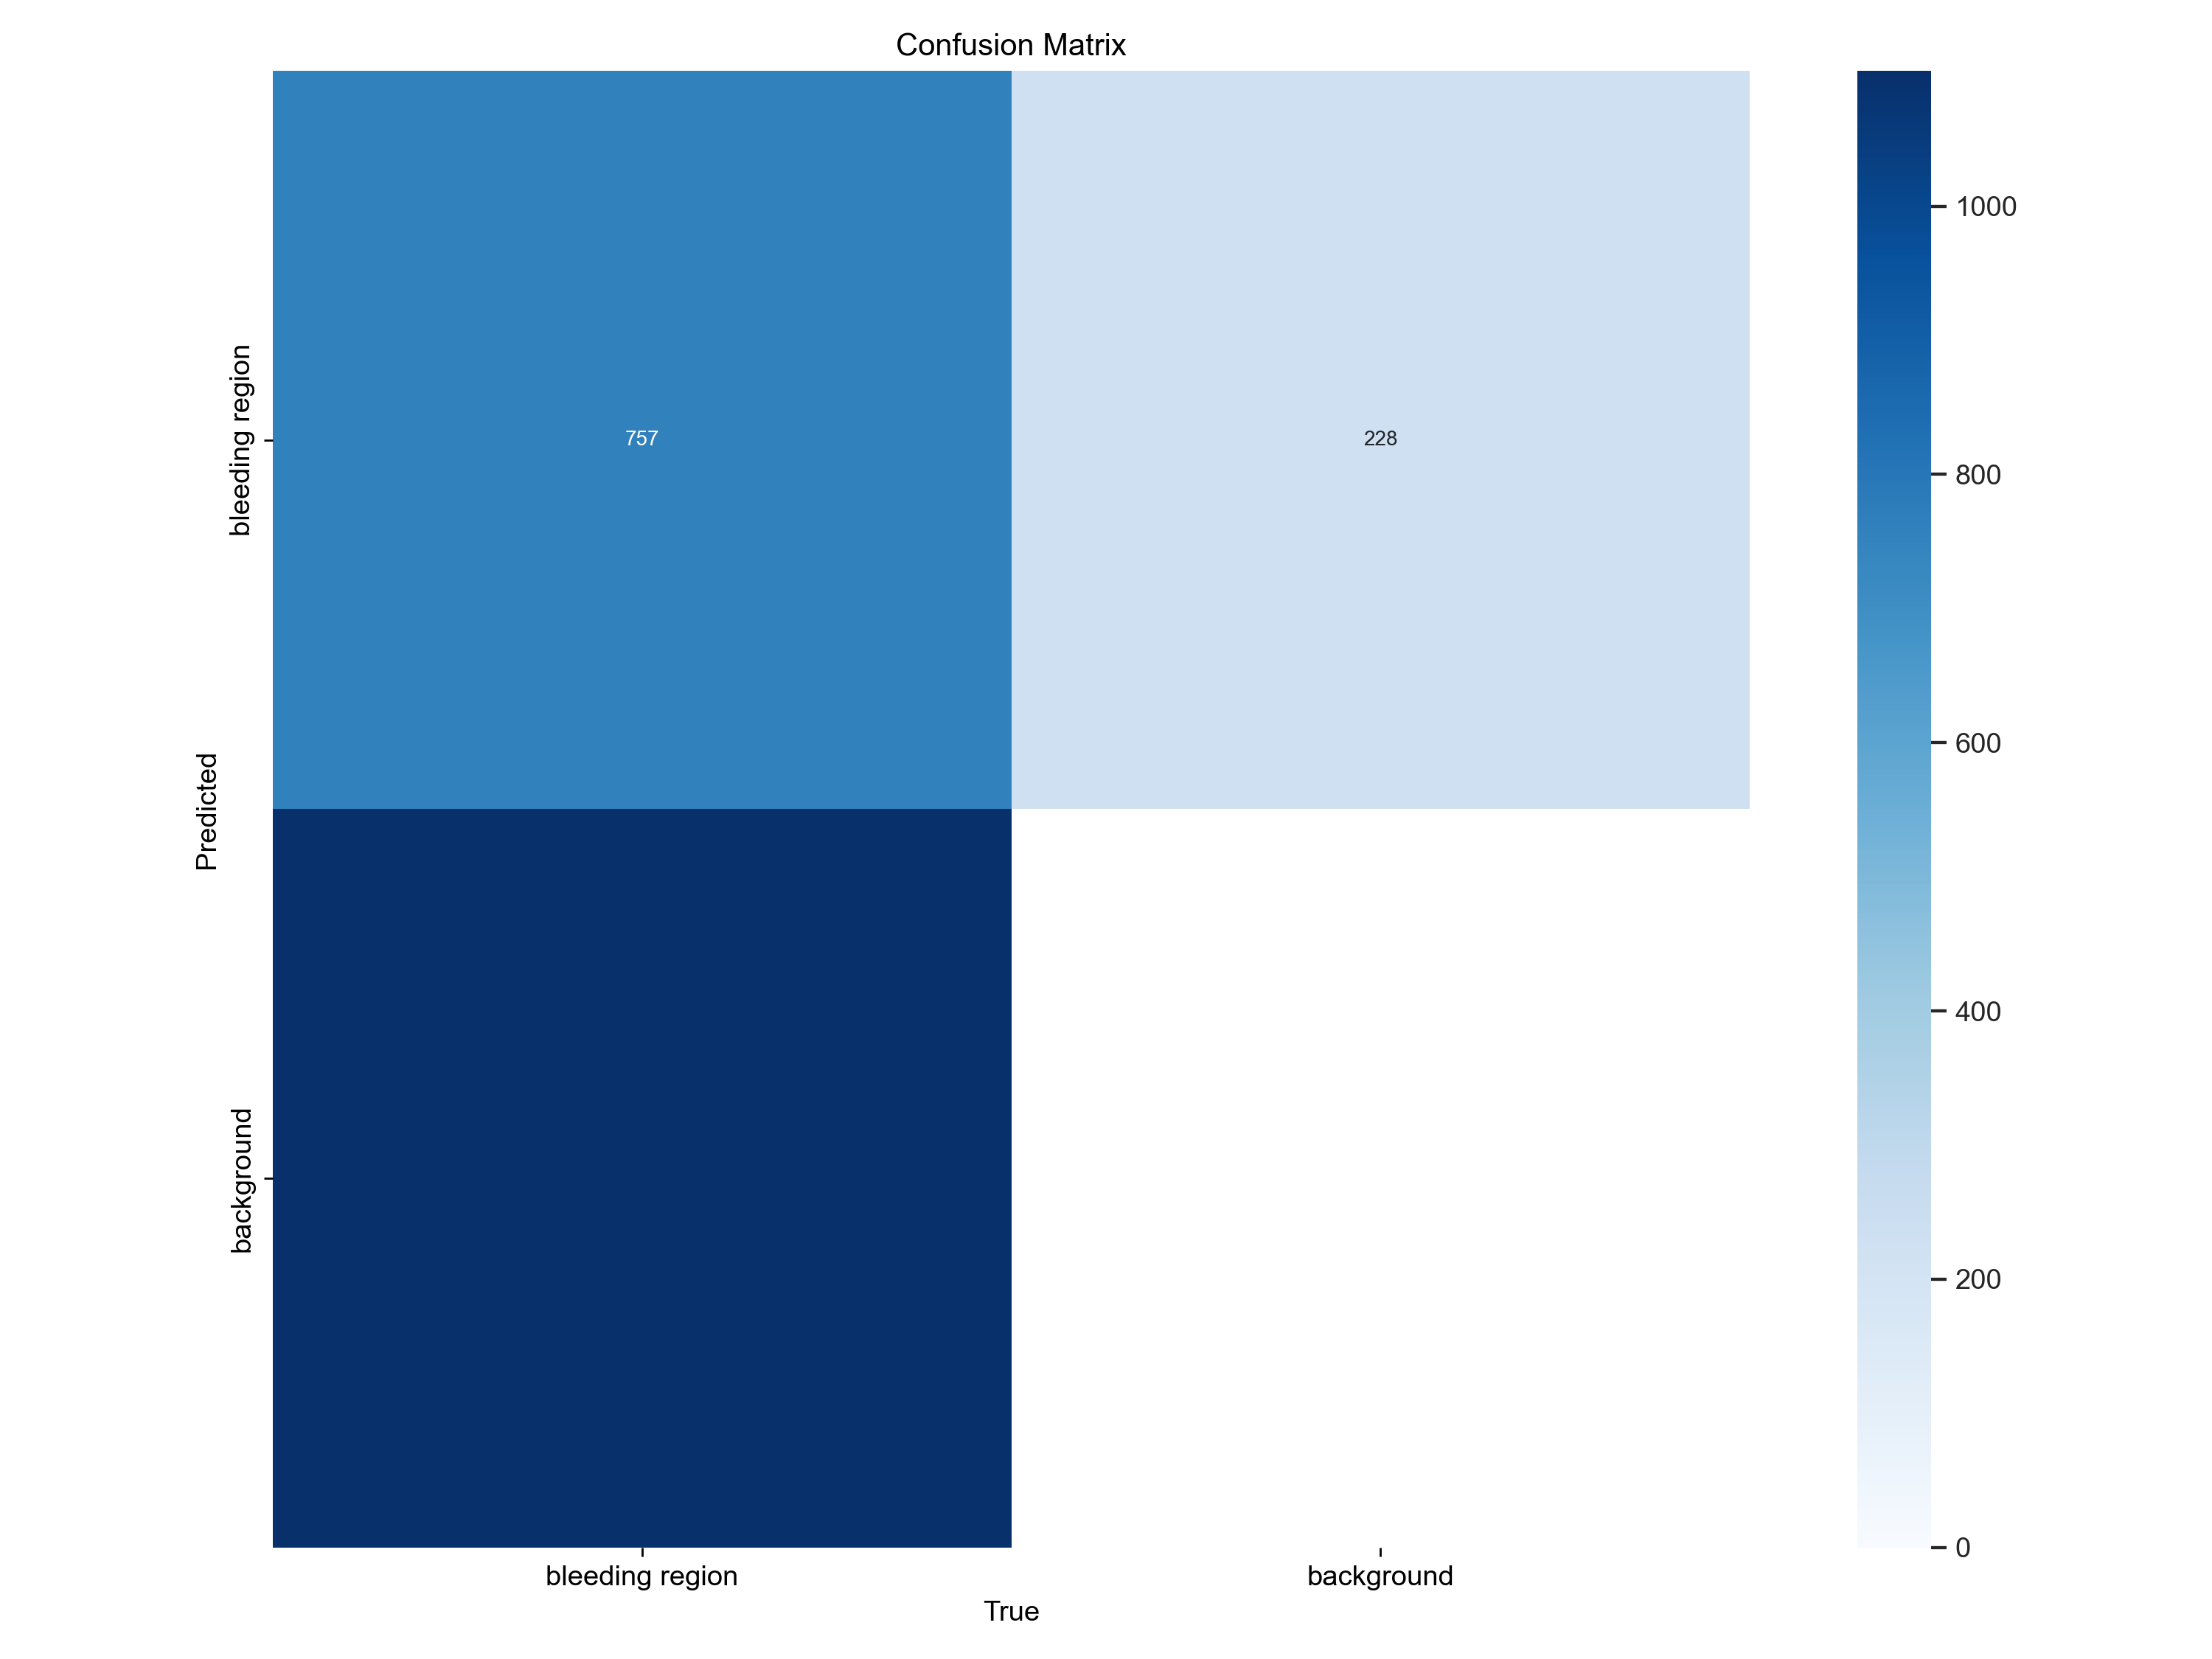

In [ ]:
Image(filename="C:/Users/Shreyank_SH/runs/detect/train4/confusion_matrix.png", width=600)

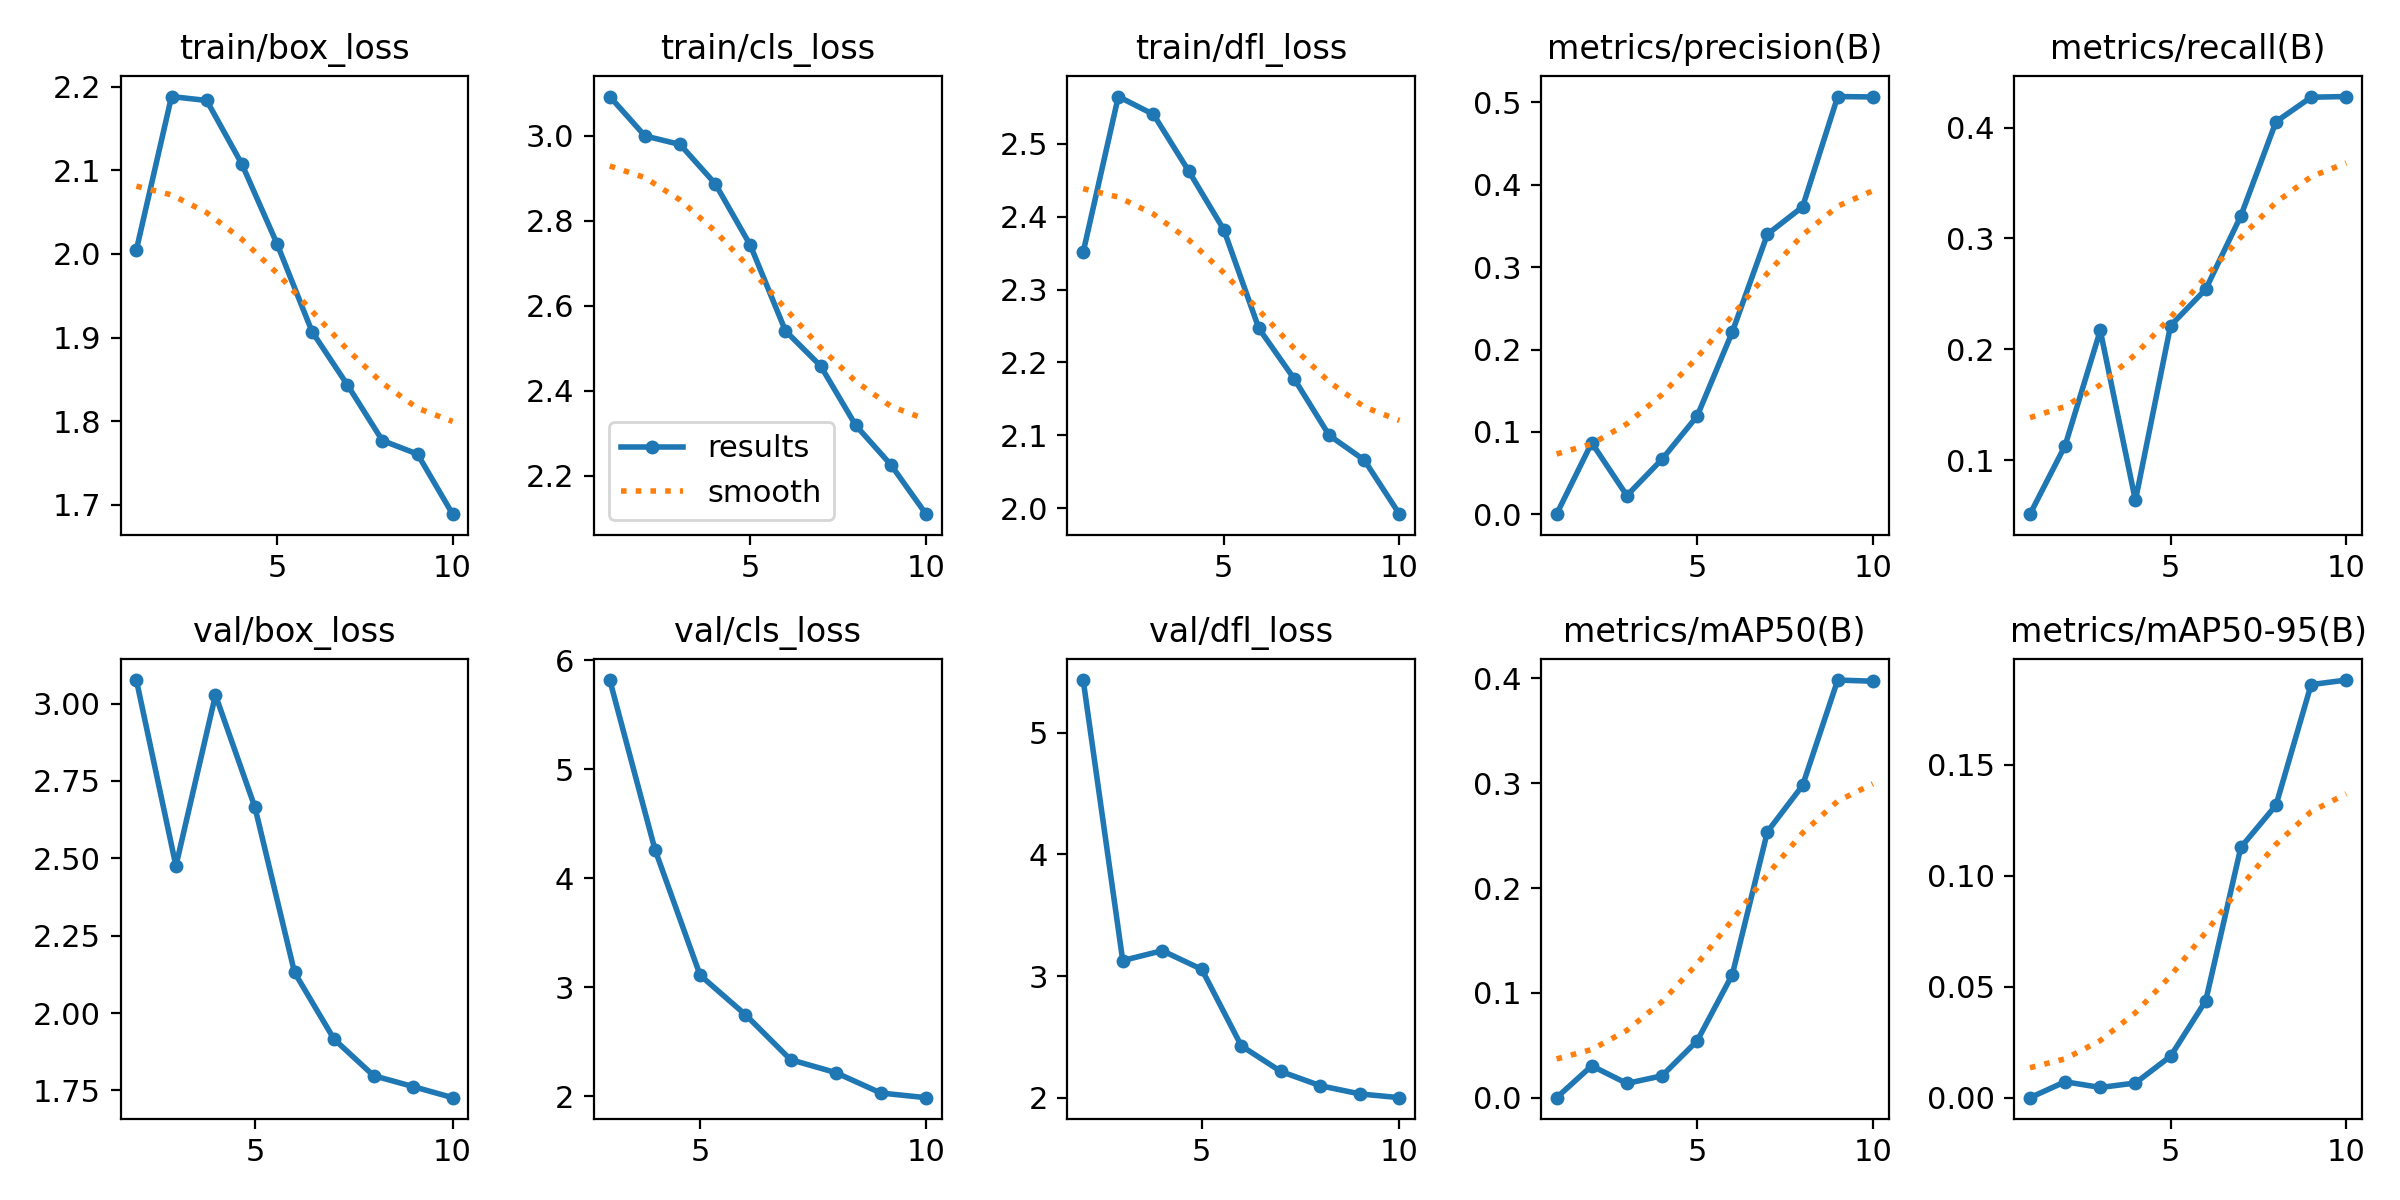

In [ ]:
Image(filename="C:/Users/Shreyank_SH/runs/detect/train4/results.png", width=600)

### Model Validation

In [4]:
torch.cuda.empty_cache()
!yolo task=detect mode=val model="C:/Users/Shreyank_SH/runs/detect/train4/weights/best.pt" data=data.yaml

Ultralytics YOLOv8.2.10 🚀 Python-3.11.7 torch-2.3.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 218 layers, 25840339 parameters, 0 gradients, 78.7 GFLOPs
val: New cache created: C:\Users\Shreyank_SH\OneDrive\Desktop\RVU\sem4\IML\SEM_LONG\WCEBleedGen_dataset\bleeding\val.cache
                   all         37         42      0.526      0.429       0.45      0.269
Speed: 2.4ms preprocess, 22.5ms inference, 0.0ms loss, 26.5ms postprocess per image
Results saved to c:\Users\Shreyank_SH\runs\detect\val3
💡 Learn more at https://docs.ultralytics.com/modes/val



val: Scanning C:\Users\Shreyank_SH\OneDrive\Desktop\RVU\sem4\IML\SEM_LONG\WCEBleedGen_dataset\bleeding\val...:   0%|          | 0/37 [00:00<?, ?it/s]
val: Scanning C:\Users\Shreyank_SH\OneDrive\Desktop\RVU\sem4\IML\SEM_LONG\WCEBleedGen_dataset\bleeding\val... 37 images, 0 backgrounds, 0 corrupt: 100%|██████████| 37/37 [00:00<00:00, 819.74it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/3 [00:00<?, ?it/s]c:\Users\Shreyank_SH\anaconda3\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  33%|███▎      | 1/3 [00:06<00:12,  6.13s/it]
                 Class

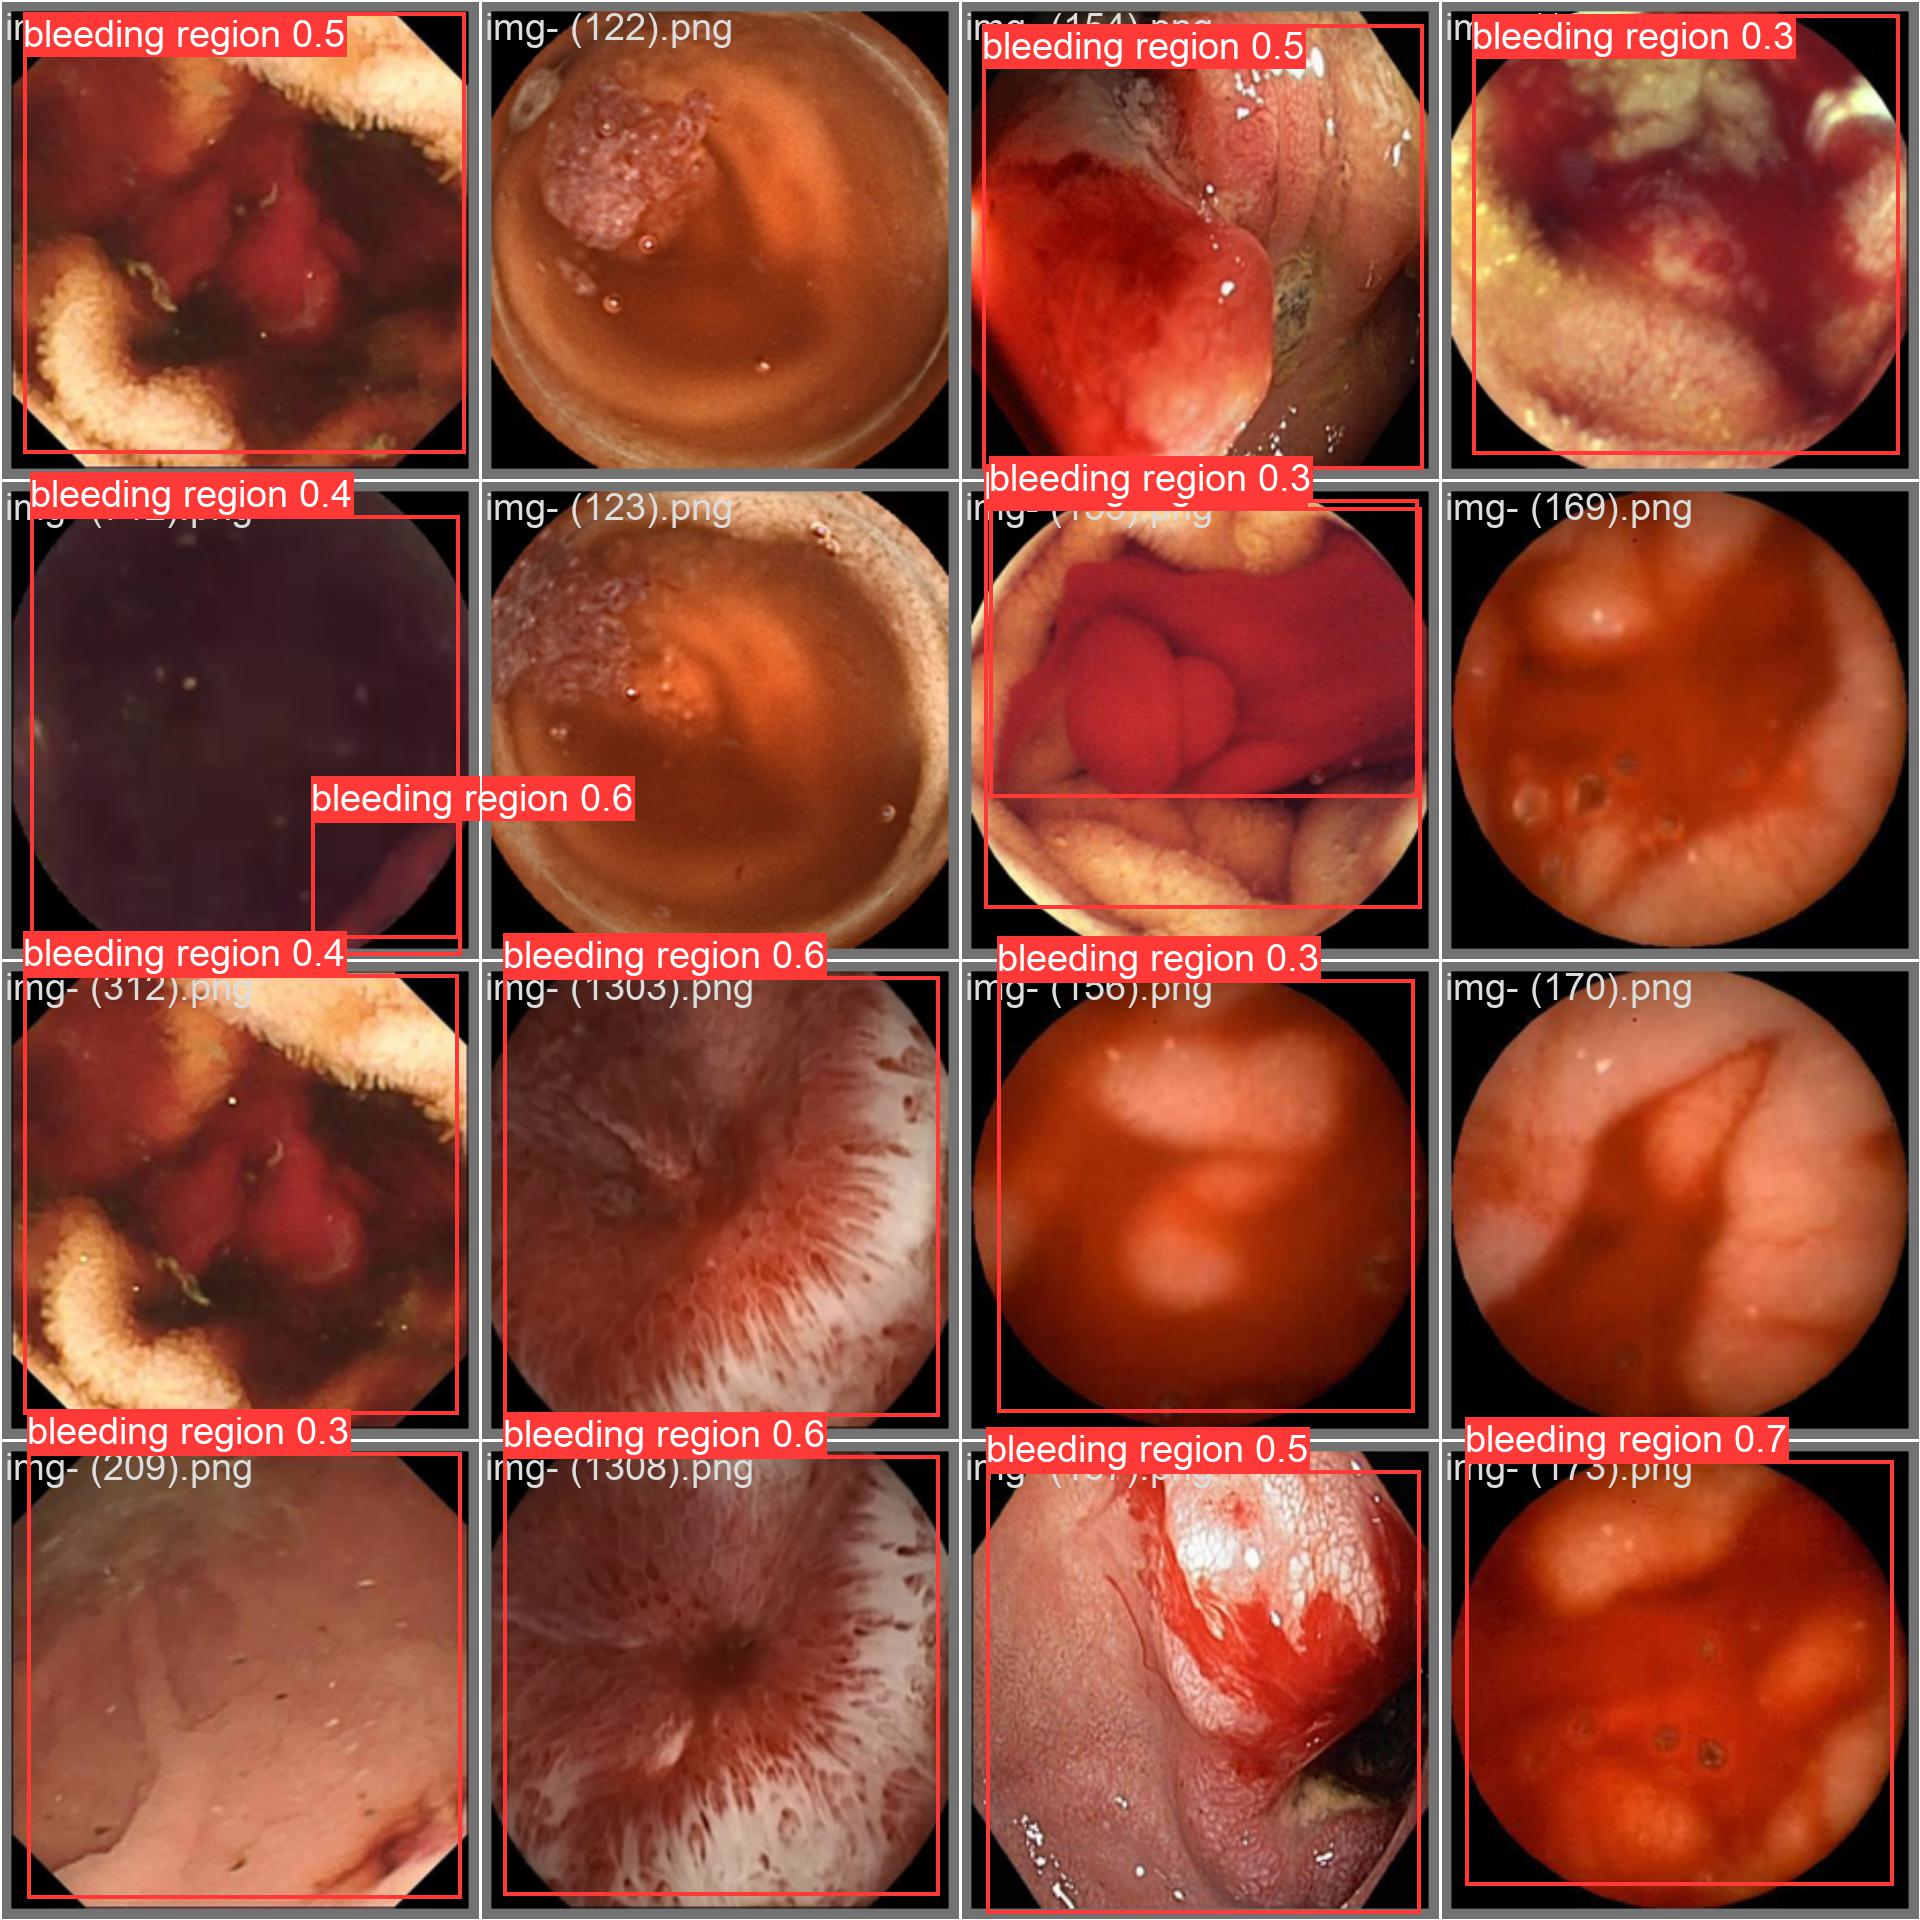

In [6]:
Image(filename="C:/Users/Shreyank_SH/runs/detect/val3/val_batch1_pred.jpg", width=600)

### Model Prediction
Passing the previoulsy classified images (Bleeding) as the unseen data for detection

In [25]:
torch.cuda.empty_cache()
!yolo task=detect mode=predict model="C:/Users/Shreyank_SH/runs/detect/train4/weights/best.pt" 
conf=0.1 save_txt=True max_det=2 
source="C:/Users/Shreyank_SH/OneDrive/Desktop/RVU/sem4/IML/SEM_LONG/Predicted_Bleeding_Images"

Ultralytics YOLOv8.2.10 🚀 Python-3.11.7 torch-2.3.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 218 layers, 25840339 parameters, 0 gradients, 78.7 GFLOPs

image 1/211 C:\Users\Shreyank_SH\OneDrive\Desktop\RVU\sem4\IML\SEM_LONG\Predicted_Bleeding_Images\A0051.png: 640x640 (no detections), 20.0ms
image 2/211 C:\Users\Shreyank_SH\OneDrive\Desktop\RVU\sem4\IML\SEM_LONG\Predicted_Bleeding_Images\A0064.png: 640x640 (no detections), 22.0ms
image 3/211 C:\Users\Shreyank_SH\OneDrive\Desktop\RVU\sem4\IML\SEM_LONG\Predicted_Bleeding_Images\A0088.png: 640x640 (no detections), 22.0ms
image 4/211 C:\Users\Shreyank_SH\OneDrive\Desktop\RVU\sem4\IML\SEM_LONG\Predicted_Bleeding_Images\A0091.png: 640x640 (no detections), 21.0ms
image 5/211 C:\Users\Shreyank_SH\OneDrive\Desktop\RVU\sem4\IML\SEM_LONG\Predicted_Bleeding_Images\A0096.png: 640x640 1 bleeding region, 21.0ms
image 6/211 C:\Users\Shreyank_SH\OneDrive\Desktop\RVU\sem4\IML\SEM_LONG\Predicted_Bleeding_Images\A0

### Displaying few images:

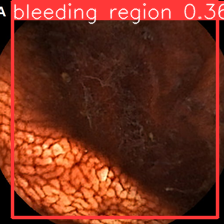

In [32]:
Image(filename="C:/Users/Shreyank_SH/runs/detect/predict5/A0156.png", width=300)

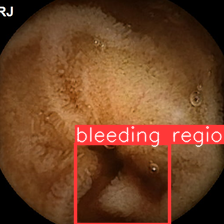

In [33]:
Image(filename="C:/Users/Shreyank_SH/runs/detect/predict5/A0467.png", width=300)

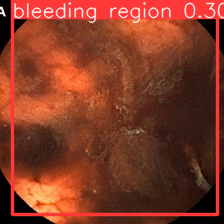

In [34]:
Image(filename="C:/Users/Shreyank_SH/runs/detect/predict5/A0184.png", width=300)

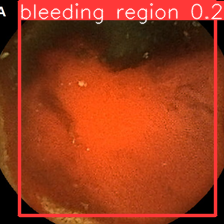

In [35]:
Image(filename="C:/Users/Shreyank_SH/runs/detect/predict5/A0243.png", width=300)